In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load data


In [2]:
train = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv')
test = pd.read_csv('/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv')

# Identify label column
label_column = 'label'

# Inspect unique labels before encoding


In [3]:
print(f"Unique labels in training set ({label_column}):", train[label_column].unique())
print(f"Unique labels in testing set ({label_column}):", test[label_column].unique())

Unique labels in training set (label): [0 1]
Unique labels in testing set (label): [0 1]


# Encode 'Label' column for binary classification
### Assuming 'Normal' is the only non-attack label


In [4]:
train[label_column] = train[label_column].apply(lambda x: 0 if x == 'Normal' else 1)
test[label_column] = test[label_column].apply(lambda x: 0 if x == 'Normal' else 1)

# Confirm encoding

In [5]:
print(f"Unique labels after encoding ({label_column}):", train[label_column].unique())


Unique labels after encoding (label): [1]


# Define categorical and numerical features
# Include 'attack_cat' and any other categorical features

In [6]:
categorical = ['proto', 'service', 'state', 'attack_cat']
numerical = [col for col in train.columns if col not in categorical + [label_column]]

# Verify no categorical features are missing


In [7]:
print("Categorical features:", categorical)
print("Numerical features:", numerical)

Categorical features: ['proto', 'service', 'state', 'attack_cat']
Numerical features: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']


# Inspect the first few rows to identify any unexpected categorical data


In [8]:
print("Training set sample:")
print(train.head())

print("Testing set sample:")
print(test.head())


Training set sample:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2      

# Define ColumnTransformer for preprocessing

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', StandardScaler(), numerical)
    ]
)

# Separate features and labels

In [10]:
X_train = train.drop([label_column], axis=1)
y_train = train[label_column]
X_test = test.drop([label_column], axis=1)
y_test = test[label_column]


# Fit and transform the training data, transform the test data

In [11]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Verify the transformed data

In [12]:
print(f"Processed training features shape: {X_train_processed.shape}")
print(f"Processed testing features shape: {X_test_processed.shape}")

Processed training features shape: (82332, 201)
Processed testing features shape: (175341, 201)


# Define the TensorFlow model

In [13]:
input_dim = X_train_processed.shape[1]
num_classes = 1 

model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')
])
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Train the model with Early Stopping

In [14]:
history = model.fit(
    X_train_processed, y_train,
    validation_data=(X_test_processed, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9837 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 3.2523e-07
Epoch 2/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 7.5060e-06 - val_accuracy: 1.0000 - val_loss: 3.1015e-08
Epoch 3/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 2.4783e-06 - val_accuracy: 1.0000 - val_loss: 5.8957e-09
Epoch 4/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 9.5932e-07 - val_accuracy: 1.0000 - val_loss: 1.6080e-09
Epoch 5/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 3.7814e-07 - val_accuracy: 1.0000 - val_loss: 5.0287e-10
Epoch 6/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 1.0000 - loss: 1.9508e-07 - val_accuracy: 1.0000 - val_loss: 1.6694e-10
Epoch 7/30
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 1.0536e-07 - val_accuracy: 1.0000 - val_loss: 5.5198e-11
Epoch 8/30
1287/1287 ━━━━━━━━━━

# Plot training & validation accuracy and loss
## Accuracy plot


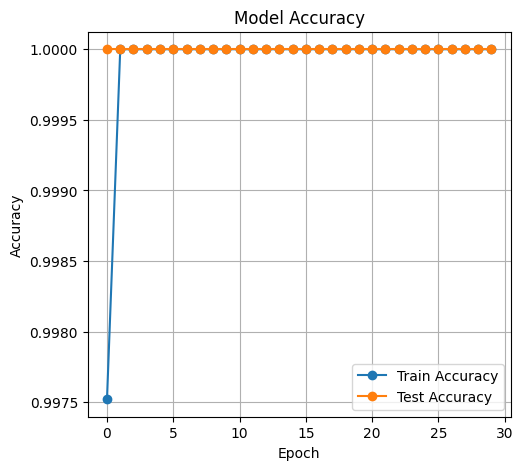

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


## Loss plot

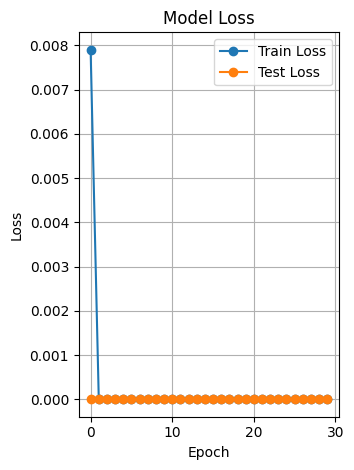

In [16]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the model

In [17]:
model.save("intrusion_detection_model.h5")